In [1]:
#importing neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Loading the Data
df_train = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
df_test = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/test_users.csv.zip')
df_train.shape, df_test.shape

((213451, 16), (62096, 15))

In [3]:
labels = df_train.country_destination.values
id_test = df_test.id
df_train.drop(['country_destination'], axis = 1)
#Concatenating train and test data for EDA
df_all = pd.concat((df_train, df_test), axis = 0, ignore_index= True)

In [4]:
df_all.shape

(275547, 16)

In [5]:
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,20090319043255
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,20090609231247
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,20091208061105


In [6]:
#Finding the number of null entries in each column.
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(i + " has {} null values.".format(ab))
        print()

age has 116866 null values.

country_destination has 62096 null values.

date_first_booking has 186639 null values.

first_affiliate_tracked has 6085 null values.



In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 16 columns):
affiliate_channel          275547 non-null object
affiliate_provider         275547 non-null object
age                        158681 non-null float64
country_destination        213451 non-null object
date_account_created       275547 non-null object
date_first_booking         88908 non-null object
first_affiliate_tracked    269462 non-null object
first_browser              275547 non-null object
first_device_type          275547 non-null object
gender                     275547 non-null object
id                         275547 non-null object
language                   275547 non-null object
signup_app                 275547 non-null object
signup_flow                275547 non-null int64
signup_method              275547 non-null object
timestamp_first_active     275547 non-null int64
dtypes: float64(1), int64(2), object(13)
memory usage: 33.6+ MB


In [8]:
df_all = df_all.drop(['id','country_destination','date_first_booking'], axis = 1)

In [9]:
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(i + " has {} null values.".format(ab))
        print()

age has 116866 null values.

first_affiliate_tracked has 6085 null values.



In [10]:
df_all.head()

,affiliate_channel,affiliate_provider,age,date_account_created,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,2010-06-28,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,facebook,20090319043255
1,seo,google,38.0,2011-05-25,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,2010-09-28,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,20090609231247
3,direct,direct,42.0,2011-12-05,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,2010-09-14,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,basic,20091208061105


In [11]:
df_all.gender.value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

In [12]:
df_all.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [13]:
df_all[df_all['age']<15].age = np.nan
df_all[df_all['age']>=100].age = np.nan

In [14]:
#Converting below columns as categories for plotting in graphs
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

for categorical_feature in categorical_features:
    df_all[categorical_feature] = df_all[categorical_feature].astype('category')

In [15]:
df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'])
df_all['timestamp_first_active'] = pd.to_datetime(df_all['timestamp_first_active'], format='%Y%m%d%H%M%S')

# Visualizations

#### Univariate plots

In [16]:
sns.set_style('whitegrid')
sns.set_context("talk")

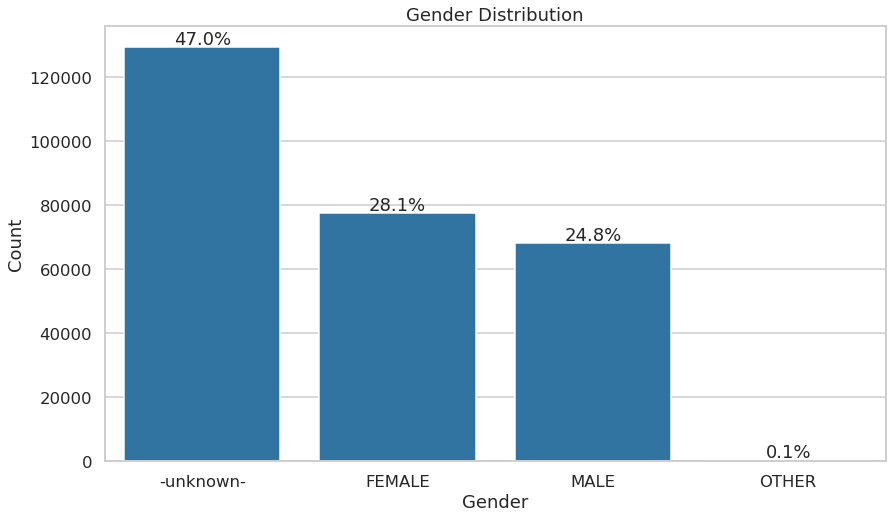

In [17]:
#Finding the gender distribution

plt.figure(figsize=(14,8))
order1 = df_all['gender'].value_counts().index
sns.countplot(data = df_all, x = 'gender', order = order1, color = sns.color_palette()[0])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
order2 = df_all['gender'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_all.shape[0])
    plt.text(i,count+1000,strt,ha='center')

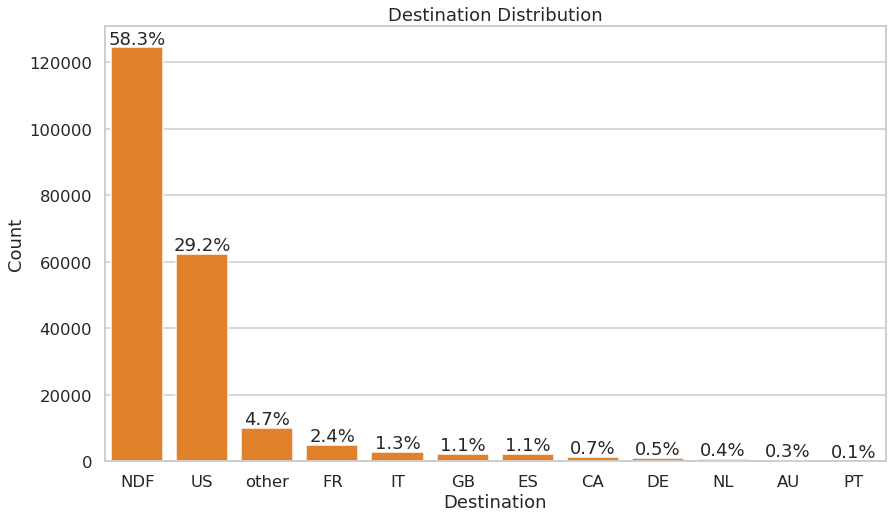

In [18]:
#Finding Destination Distribution.

plt.figure(figsize=(14,8))
order1 = df_train['country_destination'].value_counts().index
sns.countplot(data = df_train, x = 'country_destination', order = order1, color = sns.color_palette()[1])
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Destination Distribution')
order2 = df_train['country_destination'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_train.shape[0])
    plt.text(i,count+1000,strt,ha='center')

In [19]:
#Extracting year for date_account_created
df_all['acc_year'] = df_all['date_account_created'].dt.year


df1 = df_all.groupby('acc_year').count()
df1.head()

years = [2010,2011,2012,2013,2014]
yearsOrder=pd.api.types.CategoricalDtype(ordered=True, categories=years)
df1.reset_index(inplace = True)
df1.acc_year = df1.acc_year.astype(yearsOrder)

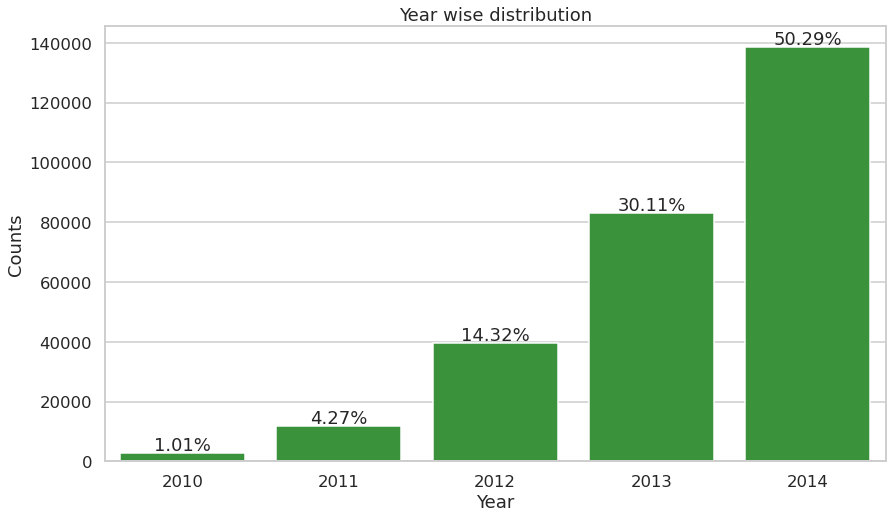

In [20]:
#Finding year-wise distribution

plt.figure(figsize=[14,8])
sns.barplot(data=df1,x='acc_year',y='affiliate_provider',color=sns.color_palette()[2]);
plt.title('Year wise distribution');
plt.xlabel('Year')
plt.ylabel('Counts')
for i in range(df1.shape[0]):
    count=df1.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+1000,strt,ha='center')

In [21]:
# Creating a month centered dataframe for 2014
df2 = df_all[df_all['date_account_created'].dt.year==2014]
df2['monthYear14'] = df2['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df2 = df2.groupby('monthYear14').count()

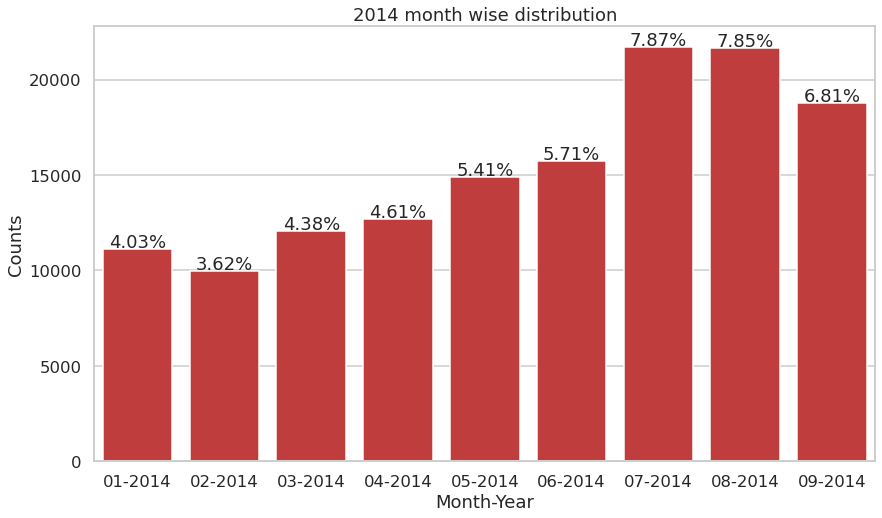

In [22]:
#Number of accounts created in different month of 2014

plt.figure(figsize=[14,8])
sns.barplot(data=df2,x=df2.index,y='affiliate_provider',color=sns.color_palette()[3]);
plt.title('2014 month wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')
for i in range(df2.shape[0]):
    count=df2.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+100,strt,ha='center')

In [23]:
#Dividing member ages into various bins

df_all['member_age_bins']=df_all['age'].apply(lambda x: '18 - 20' if 18<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else '60-70' if 60<x<=70
                                                  else '70+' if 70<x<=100
                                                  else np.nan)

In [24]:
df_all.head()

,affiliate_channel,affiliate_provider,age,date_account_created,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active,acc_year,member_age_bins
0,direct,direct,NaN,2010-06-28,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,facebook,2009-03-19 04:32:55,2010,NaN
1,seo,google,38.0,2011-05-25,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,2009-05-23 17:48:09,2011,30 - 40
2,direct,direct,56.0,2010-09-28,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,2009-06-09 23:12:47,2010,50 - 60
3,direct,direct,42.0,2011-12-05,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,2009-10-31 06:01:29,2011,40 - 50
4,direct,direct,41.0,2010-09-14,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,basic,2009-12-08 06:11:05,2010,40 - 50


In [25]:
# Creating a month centered dataframe for 2014

df3 = df_all[df_all['date_account_created'].dt.year==2013]
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df3 = df3.groupby('monthYear13').count()

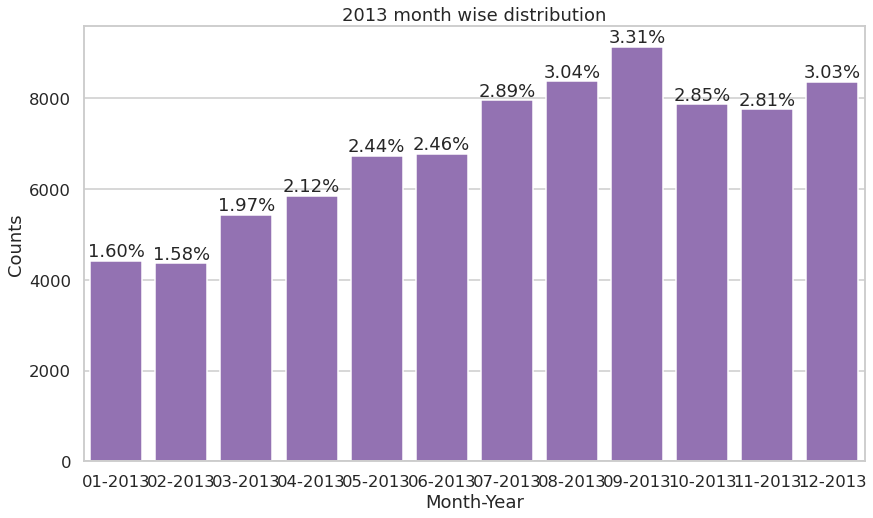

In [26]:
#Number of accounts created in different month of 2014

plt.figure(figsize=[14,8])
sns.barplot(data=df3,x=df3.index,y='affiliate_provider',color=sns.color_palette()[4]);
plt.title('2013 month wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')
for i in range(df3.shape[0]):
    count=df3.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+100,strt,ha='center')

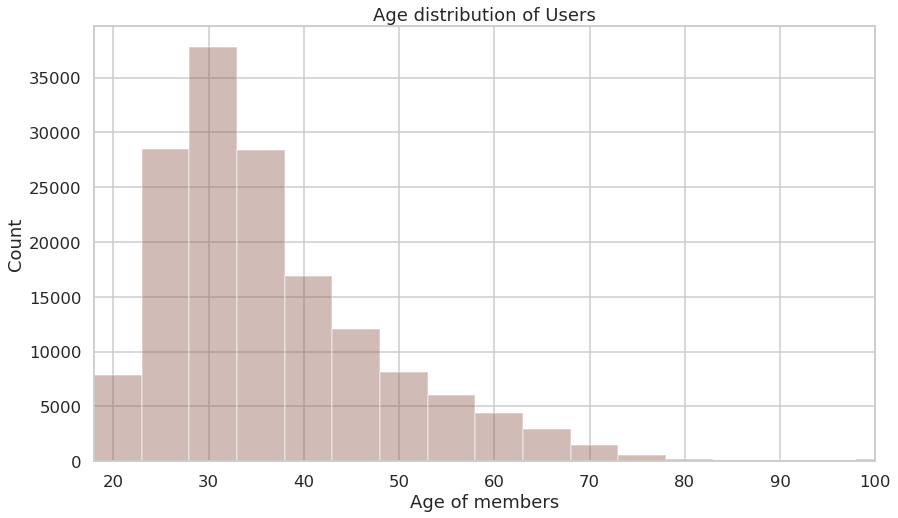

In [27]:
#Plotting Age distribution of the members
plt.figure(figsize=[14,8])
sns.distplot(df_all.age.dropna(),bins=np.arange(18,100+5,5),color=sns.color_palette()[5],kde=False);
plt.xlabel('Age of members')
plt.ylabel('Count')
plt.title('Age distribution of Users')
plt.xlim(18,100);

#### Bivariate Plots

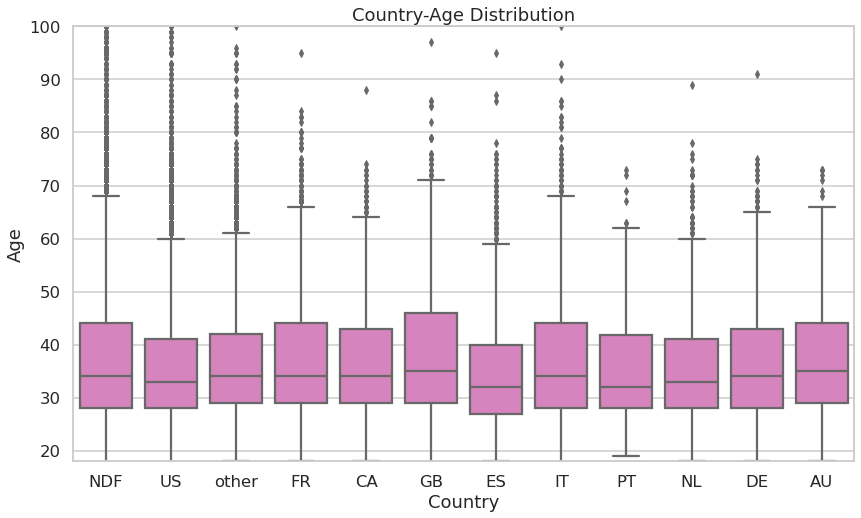

In [28]:
#Destination-Age distribution plot

plt.figure(figsize=[14,8])
sns.boxplot(data=df_train,y='age',x='country_destination',color=sns.color_palette()[6]);
plt.ylim(18,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country-Age Distribution');

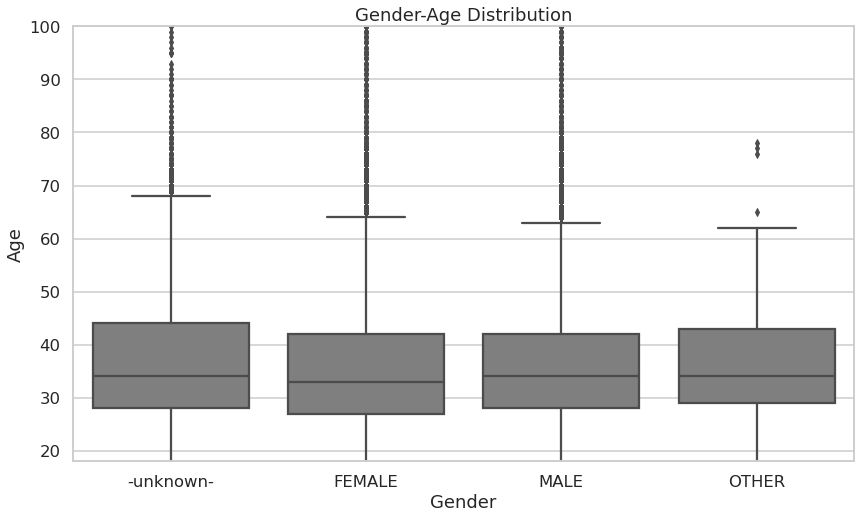

In [29]:
#Gender-Age Distribution plot

plt.figure(figsize=[14,8])
sns.boxplot(data=df_all,y='age',x='gender',color=sns.color_palette()[7]);
plt.ylim(18,100)
plt.xlabel('Gender');
plt.ylabel('Age');
plt.title('Gender-Age Distribution');

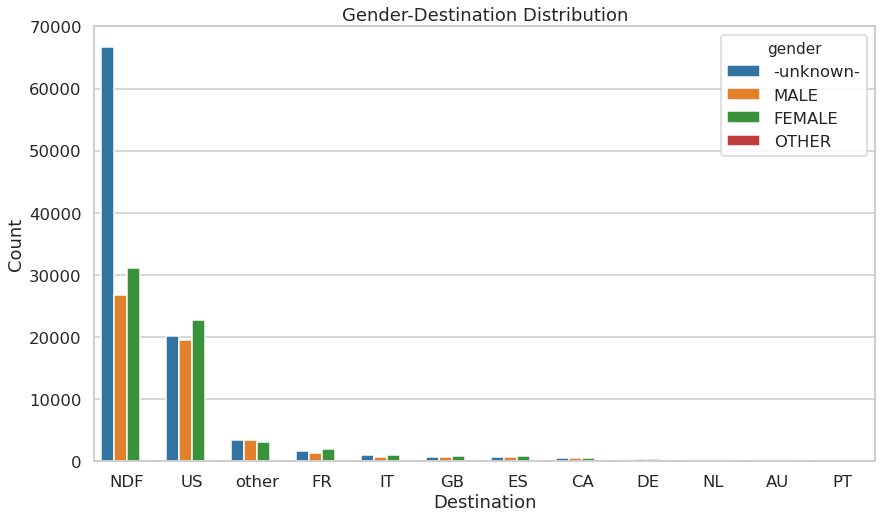

In [30]:
#Gender-Destination Distribution Plot

plt.figure(figsize=(14,8))
order1 = df_train['country_destination'].value_counts().index
sns.countplot(data = df_train, x = 'country_destination', order = order1,hue='gender')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Gender-Destination Distribution')
order2 = df_train['country_destination'].value_counts()

In [31]:
df3 = df_all[df_all['date_account_created'].dt.year==2013]
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))

df3= df3.groupby(['monthYear13','member_age_bins']).count()

df3.reset_index(inplace=True)

Text(0, 0.5, 'Counts')

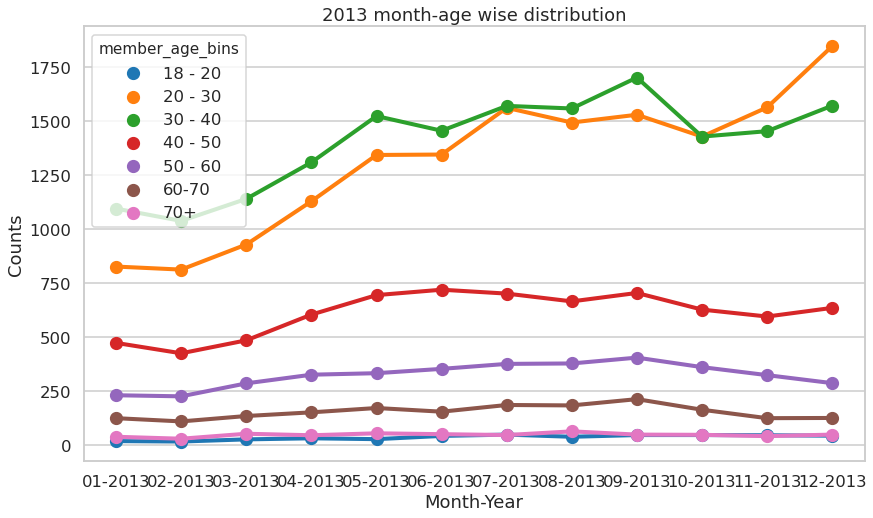

In [32]:
#Age wise distribution of the booking in different months of 2013

plt.figure(figsize=[14,8])
sns.pointplot(data=df3,x='monthYear13',y='affiliate_provider',hue='member_age_bins');
plt.title('2013 month-age wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

In [33]:
df3 = df_all[df_all['date_account_created'].dt.year==2013]
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))

df3= df3.groupby(['monthYear13','gender']).count()

df3.reset_index(inplace=True)

Text(0, 0.5, 'Counts')

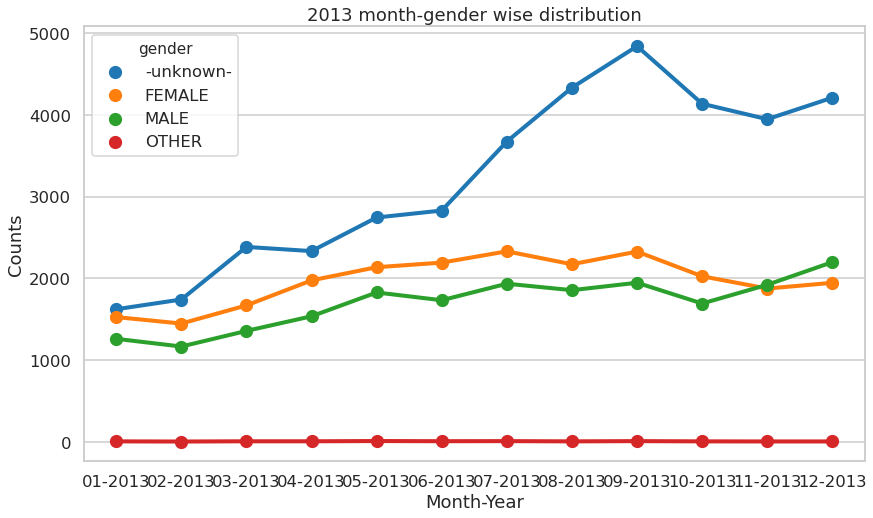

In [34]:
#Gender wise distribution of the booking in different months of 2013

plt.figure(figsize=[14,8])
sns.pointplot(data=df3,x='monthYear13',y='affiliate_provider',hue='gender');
plt.title('2013 month-gender wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

#### Multivariate Plot

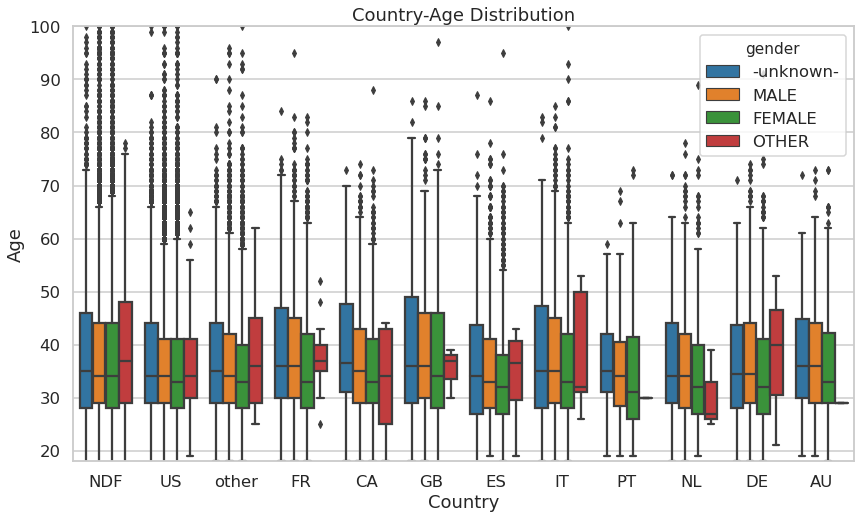

In [35]:
#Relation ship between age-gender-destination

plt.figure(figsize=[14,8])
sns.boxplot(data=df_train,y='age',x='country_destination',hue='gender');
plt.ylim(18,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country-Age Distribution');

# Computation for the Booking Destination

In [36]:
df_train = df_train.drop(['country_destination'], axis=1)

In [37]:
dfWork = pd.concat((df_train, df_test), axis=0, ignore_index=True)
dfWork = dfWork.drop(['id', 'date_first_booking'], axis=1)
#Filling nan
dfWork = dfWork.fillna(-1)


### Feature Engineering

In [38]:
#date_account_created

dac = np.vstack(dfWork.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
dfWork['dac_year'] = dac[:,0]
dfWork['dac_month'] = dac[:,1]
dfWork['dac_day'] = dac[:,2]
dfWork = dfWork.drop(['date_account_created'], axis=1)

In [39]:
#timestamp_first_active

tfa = np.vstack(dfWork.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
dfWork['tfa_year'] = tfa[:,0]
dfWork['tfa_month'] = tfa[:,1]
dfWork['tfa_day'] = tfa[:,2]
dfWork = dfWork.drop(['timestamp_first_active'], axis=1)

In [40]:
av = dfWork.age.values
dfWork['age'] = np.where(np.logical_or(av<14, av>100), -1, av)

### One hot Encoding

In [41]:
#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel',
             'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    dfWork_dummy = pd.get_dummies(dfWork[f], prefix=f)
    dfWork = dfWork.drop([f], axis=1)
    dfWork = pd.concat((dfWork, dfWork_dummy), axis=1)

In [42]:
#Splitting train and test
vals = dfWork.values
X = vals[:df_train.shape[0]]
le = LabelEncoder()
y = le.fit_transform(labels)   
X_test = vals[df_train.shape[0]:]

In [43]:
#Classifier
xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=25, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=0.5,
              tree_method=None, validate_parameters=False, verbosity=None)

In [44]:
#Prediction
y_pred = xgb.predict_proba(X_test)

In [45]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [46]:
#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('sub.csv',index=False)